In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn import preprocessing
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
raw_data = fetch_california_housing()
data = raw_data.data 

In [3]:
lower_percent = np.percentile(data, 1, axis=0)
higher_percent = np.percentile(data, 99, axis=0)

result = np.array([True for i in range(data.shape[0])])
for i in range(len(raw_data.feature_names)):
    lower = data[:,i] >= lower_percent[i]
    higher = data[:,i] <= higher_percent[i]
    result = np.logical_and(result, np.logical_and(lower, higher))
    
data = data[result]

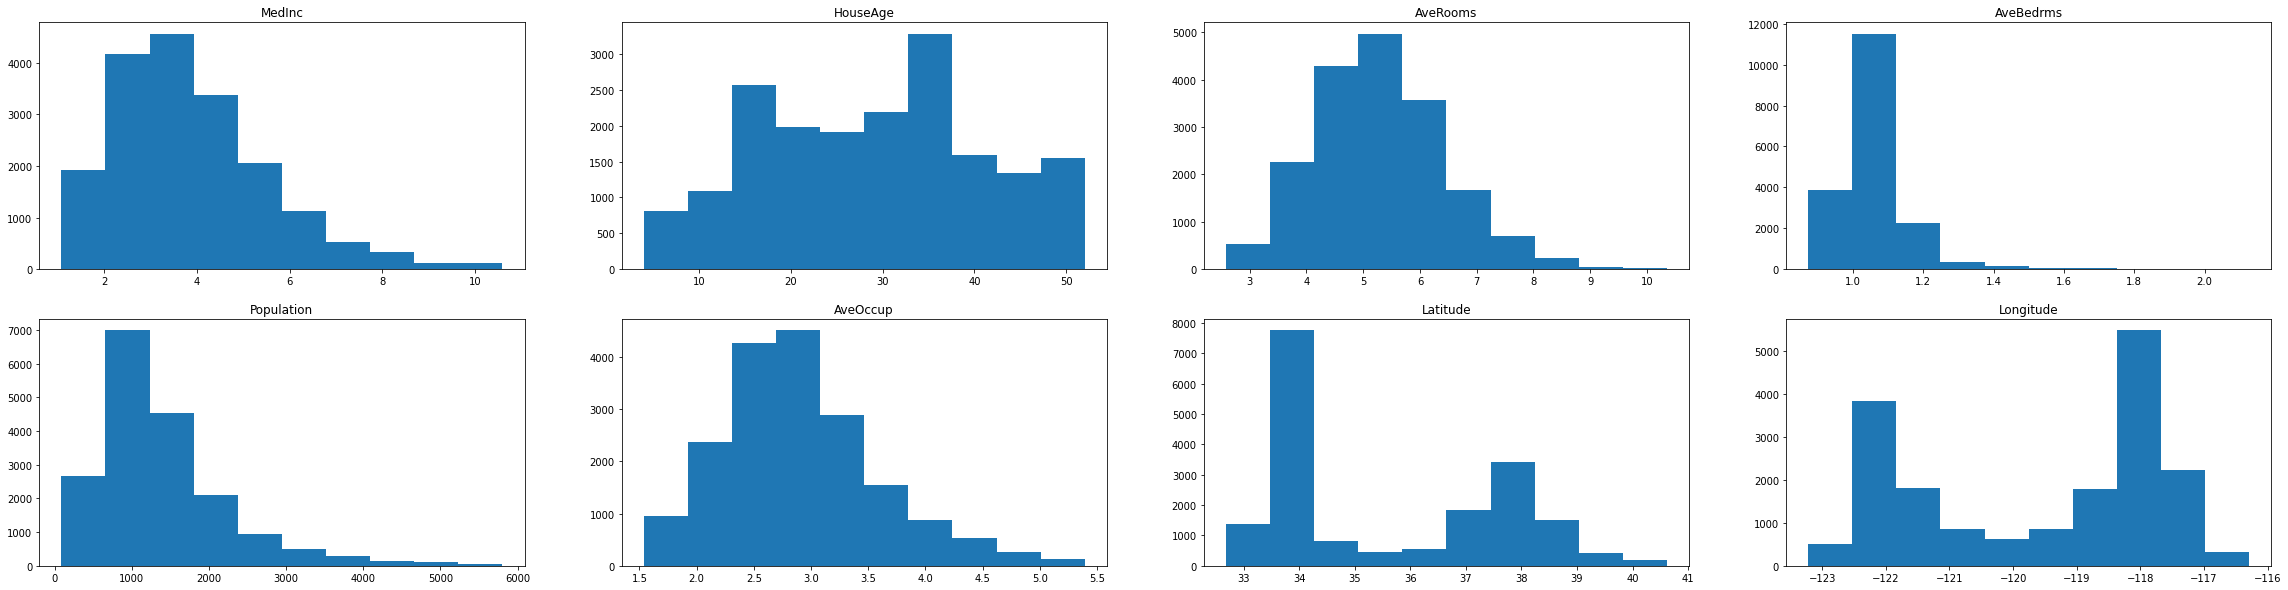

In [4]:
figs, axs = plt.subplots(2, 4, figsize=(40, 10))

for i in range(2):
    for j in range(4): 
        axs[i, j].hist(data[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
plt.show()

In [5]:
# Preprocessing 
print(data.shape)
np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10 

X_train = data[:trainset_size, :]
X_test = data[trainset_size:, :]
print(X_train.shape)
print(X_test.shape)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

(18310, 8)
(12817, 8)
(5493, 8)


In [6]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = F.relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)
        
        return mu_z, std_z 

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.input = nn.Linear(latent_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        out = F.relu(self.hidden(out))
#         out = F.relu(self.hidden2(out))
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)
        
        return mu_x, std_x

In [7]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM = 10
LATENT_DIM = 10
BATCH_SIZE = 128
N_EPOCHS = 100
lr = 1e-3

In [8]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
dec = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [9]:
avg_mu_x = torch.zeros(X_train.shape)
for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + torch.exp(std_z) * eps
    mu_x, std_x = dec(z_samples)
    avg_mu_x += mu_x

avg_mu_x /= 100
avg_mu_x.shape

avg_mu_x = avg_mu_x.detach().numpy()

In [10]:
avg_mu_x

array([[ 0.05843462, -0.00640346,  0.15743066, ...,  0.32621858,
         0.04637329, -0.09570551],
       [ 0.05848152, -0.00612628,  0.16042247, ...,  0.32592854,
         0.04592548, -0.0957953 ],
       [ 0.06025958, -0.00618971,  0.15793611, ...,  0.32662436,
         0.04696304, -0.09971268],
       ...,
       [ 0.05983198, -0.00507983,  0.15991029, ...,  0.32526195,
         0.04740635, -0.0943487 ],
       [ 0.05352835, -0.01022312,  0.15574607, ...,  0.32685158,
         0.04124198, -0.10145038],
       [ 0.0499969 , -0.01101267,  0.1523006 , ...,  0.32659176,
         0.03870932, -0.1017425 ]], dtype=float32)

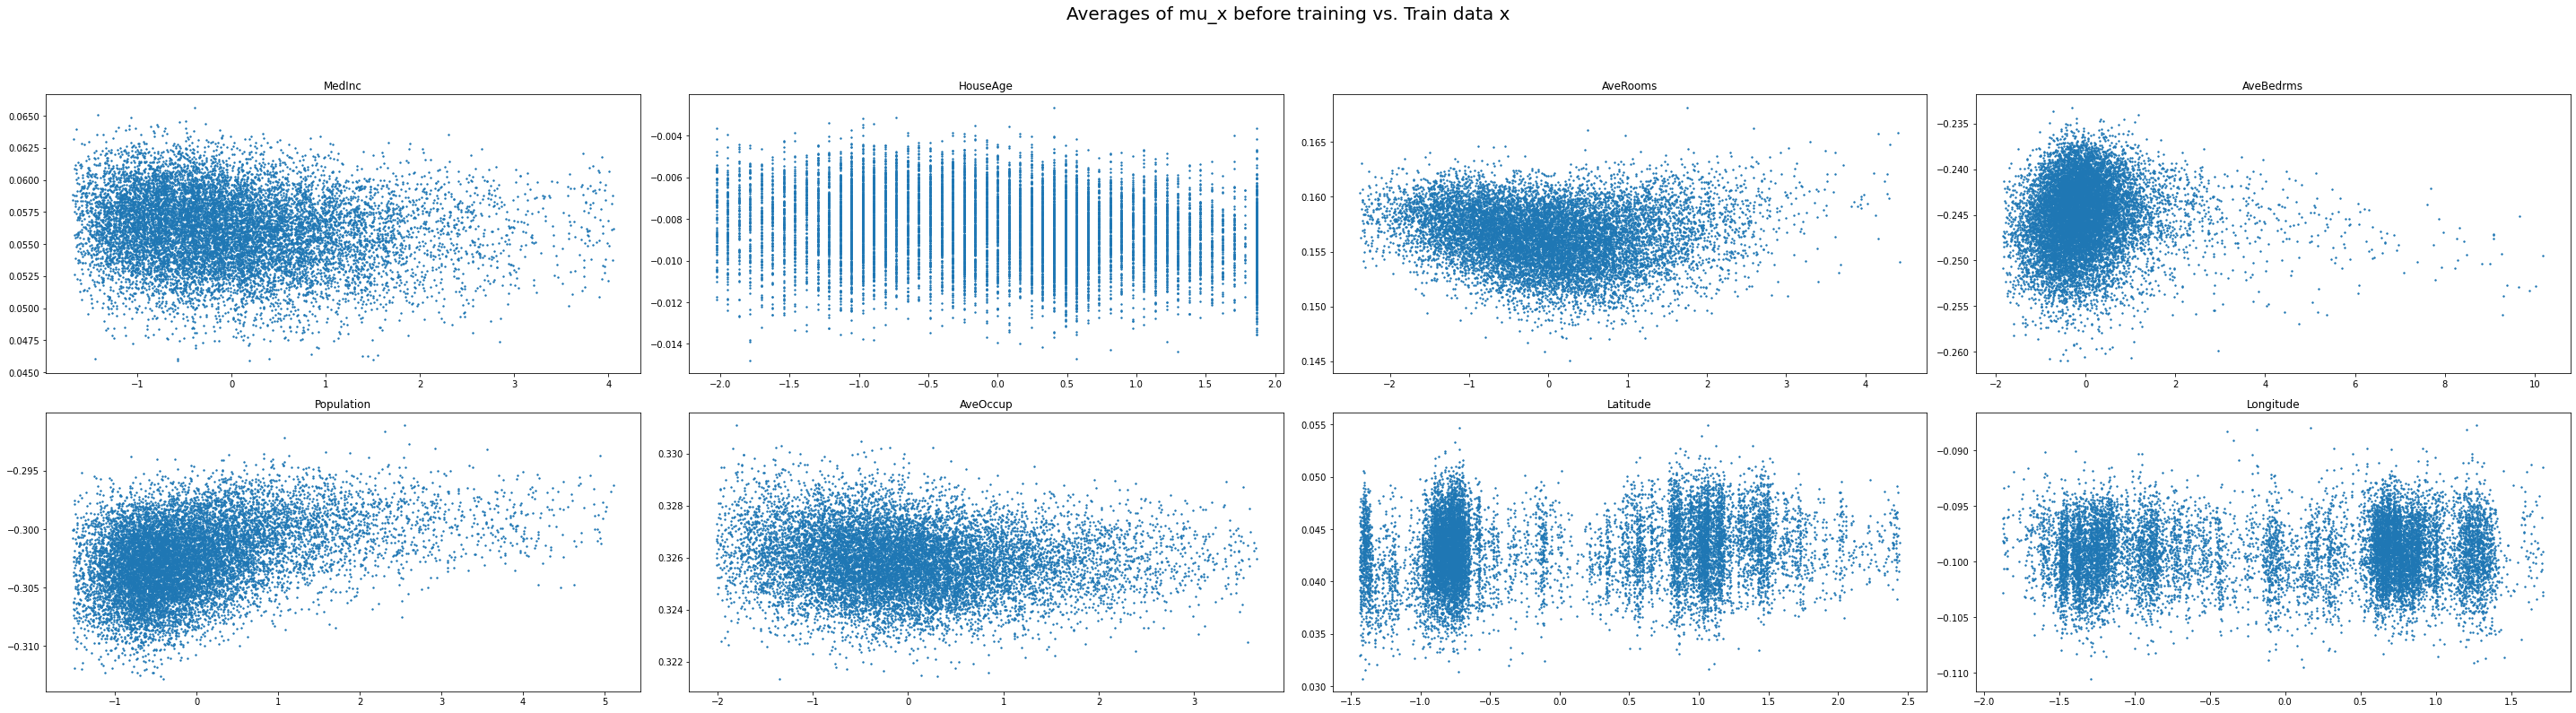

In [11]:
figs, axs = plt.subplots(2, 4, figsize=(40, 10))
for i in range(2): 
    for j in range(4): 
        axs[i, j].scatter(X_train[:, i*4+j], avg_mu_x[:,i*4+j], s=2)
        axs[i, j].set_title(raw_data.feature_names[i*4+j])

figs.tight_layout()
plt.suptitle("Averages of mu_x before training vs. Train data x", fontsize=20, y=1.1)
plt.show()

In [12]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x):
    S = x.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [13]:
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [14]:
train_iter = DataLoader(X_train, batch_size=BATCH_SIZE)
test_iter = DataLoader(X_test, batch_size=BATCH_SIZE)

In [15]:
train_loss_avg = []
test_loss_avg = []

for i in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
    for x in train_iter: 
        # Zero grad 
        optimizer.zero_grad()
        
        # Forward pass 
        mu_z, std_z = enc(x)
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)
        mu_x, std_x = dec(z_samples)
        
        # Loss 
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward
        loss.backward()
        
        # Update 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
#     scheduler.step()
    train_loss_avg[-1] /= num_batches
    
    test_loss_avg.append(0)
    num_batches = 0
    for x_test in test_iter:
        # test
        mu_z_test, std_z_test = enc(x_test)
        eps_test = torch.randn_like(std_z_test)
        z_samples_test = mu_z_test + eps_test * torch.exp(std_z_test)

        mu_x_test, std_x_test = dec(z_samples_test)

        # loss 
        test_loss = loss_fn(mu_z_test, std_z_test, z_samples_test, mu_x_test, std_x_test, x_test)
        test_loss_avg[-1] += test_loss.item()
        num_batches += 1
    test_loss_avg[-1] /= num_batches
    
    print("Epoch [%d / %d] train loss: %f, test loss: %f" % (i+1, N_EPOCHS, train_loss_avg[-1], test_loss_avg[-1]))

Epoch [1 / 100] train loss: 11.905344, test loss: 11.526813
Epoch [2 / 100] train loss: 11.424009, test loss: 11.432926
Epoch [3 / 100] train loss: 11.369390, test loss: 11.375421
Epoch [4 / 100] train loss: 11.324390, test loss: 11.306377
Epoch [5 / 100] train loss: 11.230503, test loss: 11.203469
Epoch [6 / 100] train loss: 11.152521, test loss: 11.159128
Epoch [7 / 100] train loss: 11.122939, test loss: 11.118970
Epoch [8 / 100] train loss: 11.097794, test loss: 11.122790
Epoch [9 / 100] train loss: 11.086265, test loss: 11.089939
Epoch [10 / 100] train loss: 11.070246, test loss: 11.060392
Epoch [11 / 100] train loss: 11.045423, test loss: 11.046848
Epoch [12 / 100] train loss: 11.032262, test loss: 11.037854
Epoch [13 / 100] train loss: 11.015198, test loss: 11.011587
Epoch [14 / 100] train loss: 11.001415, test loss: 11.000035
Epoch [15 / 100] train loss: 10.984955, test loss: 10.982261
Epoch [16 / 100] train loss: 10.966581, test loss: 10.966417
Epoch [17 / 100] train loss: 10.9

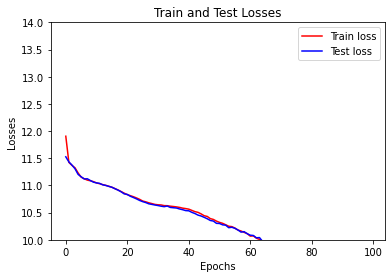

In [16]:
plt.plot(train_loss_avg, "r")
plt.plot(test_loss_avg, "b")
plt.legend(["Train loss", "Test loss"])
plt.ylabel("Losses")
plt.xlabel("Epochs")
# plt.ylim(10, 14)
plt.title("Train and Test Losses")
plt.show()

In [17]:
avg_mu_x_trained = torch.zeros(X_train.shape)
for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)
    mu_x, std_x = dec(z_samples)
    avg_mu_x_trained += mu_x

avg_mu_x_trained /= 100
avg_mu_x_trained = avg_mu_x_trained.detach().numpy()

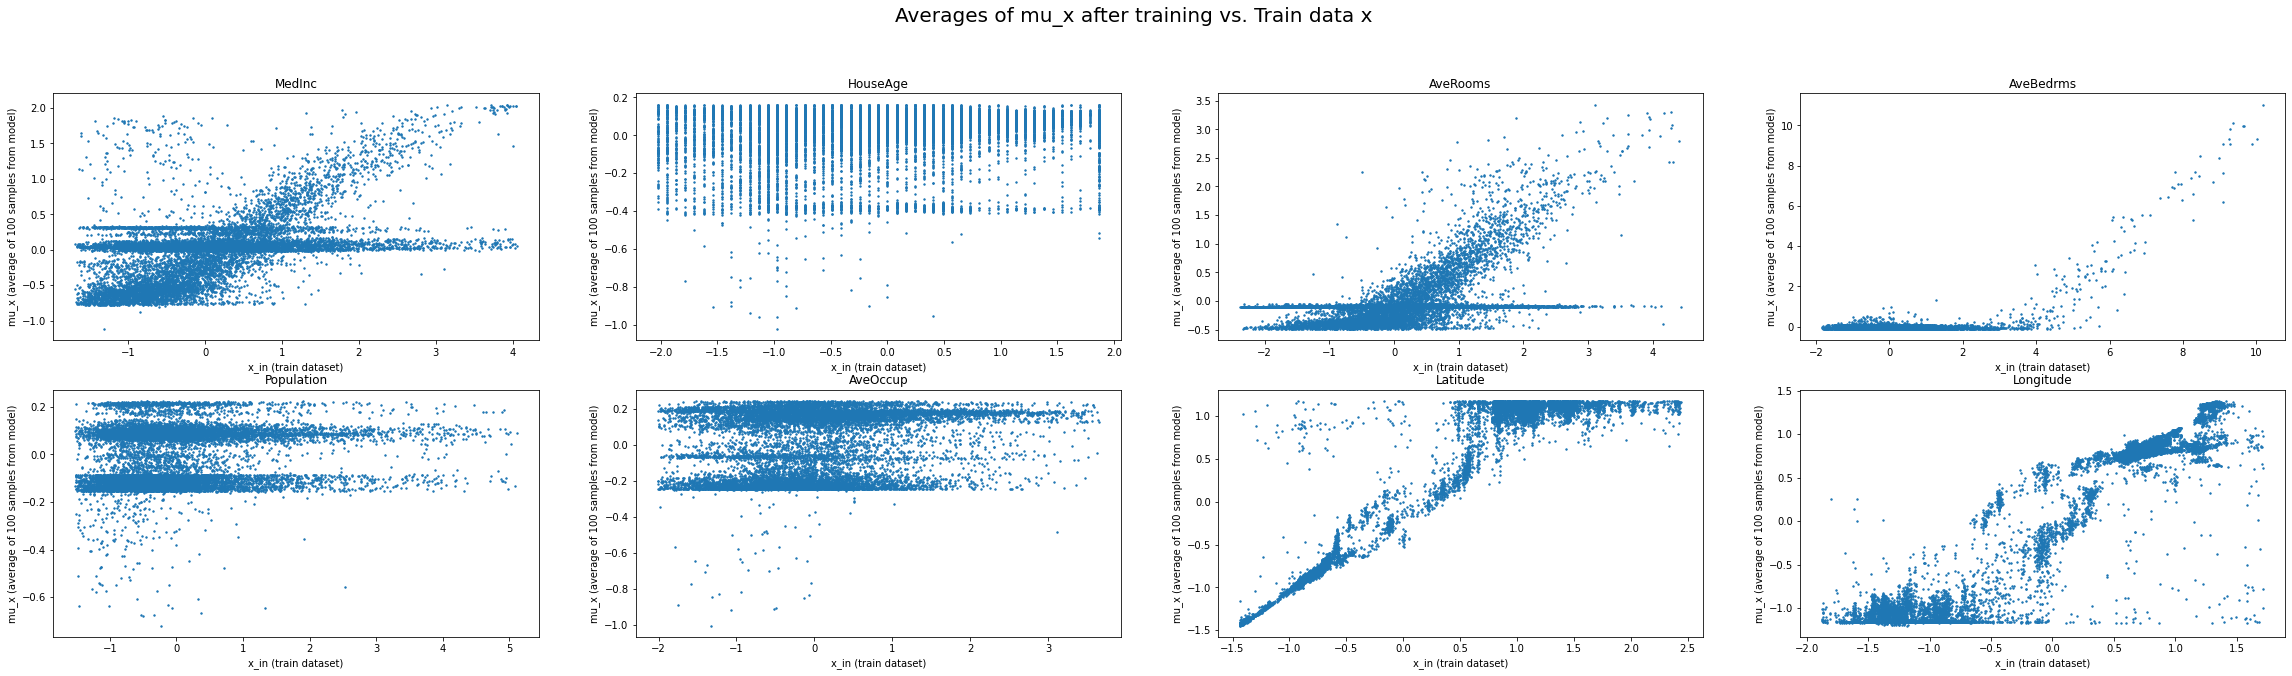

In [18]:
# avg_mu_x_trained = avg_mu_x_trained.detach().numpy()
figs, axs = plt.subplots(2, 4, figsize=(40, 10))
count = 0 
for i in range(2):
    for j in range(4):
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x_trained[:,i*4+j], s=2)
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
        axs[i, j].set_xlabel("x_in (train dataset)")

plt.suptitle("Averages of mu_x after training vs. Train data x", fontsize=20, y=1)
plt.show()

In [19]:
import matplotlib.colors as mcolors
import seaborn as sns

levs = range(12)
assert len(levs) % 2 == 0, 'N levels must be even.'

cmap = mcolors.LinearSegmentedColormap.from_list(name='red_white_blue', 
                                                 colors =[(1, 0, 0), 
                                                          (1, 1., 1), 
                                                          (0, 0, 1)],
                                                 N=len(levs)-1)

In [20]:
p_z = torch.distributions.Normal(0, 1)
z = p_z.sample((1000, LATENT_DIM)).type(torch.float64)
mu_x, std_x = dec(z)
print(mu_x.shape)

torch.Size([1000, 8])


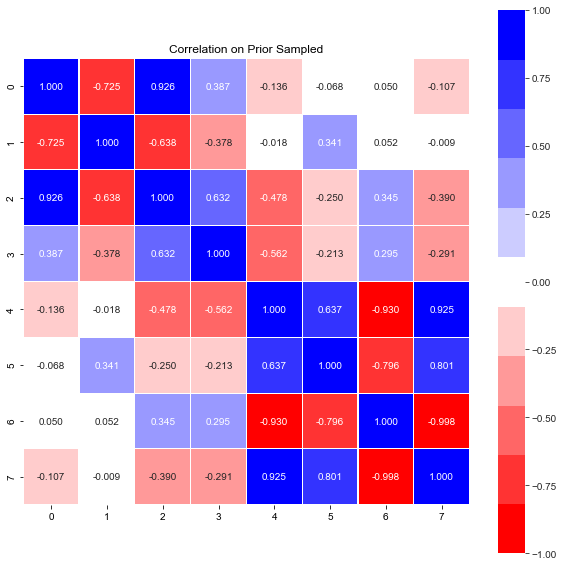

In [21]:
mu_x = mu_x.detach().numpy()
corr_eval = np.corrcoef(mu_x, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_eval, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Prior Sampled")
    plt.show()

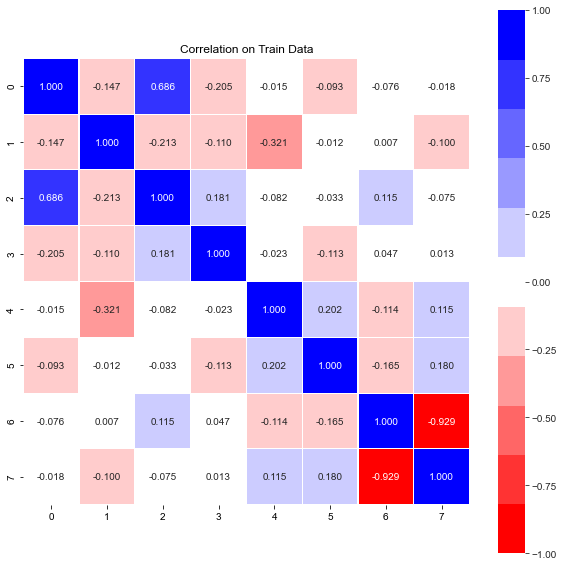

In [22]:
corr_train = np.corrcoef(X_train, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))
with sns.axes_style("white"):
    ax = sns.heatmap(corr_train, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Train Data")
    plt.show()

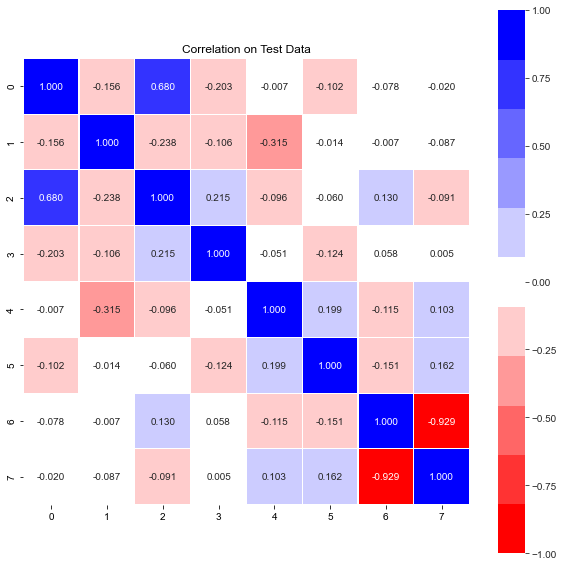

In [23]:
corr_test = np.corrcoef(X_test, rowvar=False)
fig, ax = plt.subplots(figsize=(10,10))  
with sns.axes_style("white"):
    ax = sns.heatmap(corr_test, cmap=cmap, annot=True, fmt=".3f", vmin=-1, vmax=1, annot_kws={'size':10}, linewidth=0.1, square=True)
    plt.title("Correlation on Test Data")
    plt.show()

In [24]:
# z = torch.distributions.Uniform(0, 1).sample((X_test.shape[0], LATENT_DIM)).type(torch.float64)
# mu_x, std_x = dec(z)

# # X_test = X_test.numpy()
# mu_x = mu_x.detach().numpy()

# figs, axs = plt.subplots(X_test.shape[1], 2, figsize=(20, 100))

# for i in range(X_test.shape[1]):
# #     x_test_mean = x_test[:,i].mean()
#     axs[i, 0].hist(X_test[:,i])
#     axs[i, 0].set_title("Histogram of Held Out Data on Feature " + raw_data.feature_names[i])
#     axs[i, 1].hist(mu_x[:,i])
#     axs[i, 1].set_title("Histogram of Sampled Data on Feature " + raw_data.feature_names[i])

# plt.show()